# Project Overview 

What factors of car accident contribute to different injury outcomes?

Primarily focused on interpretability

## The area's in which I look to address are:

How can this be used in the outside world?

What features did I use?

What did the visualizations tell about my data?

What does the statistical techniques conclude about my data?

What model was best fit?

## Gathered Data 
Gathered Traffic Crashes dataset from Chicago data portal


# Importing libraries

In [1]:
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import make_scorer, accuracy_score 
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics 
from sklearn.utils import resample
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import GridSearchCV
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 200)
from sklearn import metrics
%matplotlib inline

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [61]:
#Loading and concating data
people = pd.read_csv('Traffic_Crashes_-_People.csv')
df = pd.read_csv('Traffic_Crashes_-_Crashes.csv')
result=pd.merge(people, df, on=['CRASH_RECORD_ID'], how = 'inner')

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
#Initial cleaning
result.drop_duplicates(subset='CRASH_RECORD_ID', inplace=True)
A = ['REPORT_TYPE','INJURIES_TOTAL','RD_NO_y','CRASH_DATE_x','PERSON_ID','LOCATION','RD_NO_x','VEHICLE_ID','CITY','STATE','DRIVERS_LICENSE_STATE','SEAT_NO','DRIVERS_LICENSE_CLASS','HOSPITAL','EMS_AGENCY','EMS_RUN_NO','PEDPEDAL_ACTION','PEDPEDAL_VISIBILITY','PEDPEDAL_LOCATION','CELL_PHONE_USE','CRASH_DATE_EST_I','LANE_CNT','INTERSECTION_RELATED_I','NOT_RIGHT_OF_WAY_I','BAC_RESULT VALUE','HIT_AND_RUN_I','PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','DOORING_I','WORK_ZONE_I','WORK_ZONE_TYPE', 'WORKERS_PRESENT_I']     
result.drop(A,axis=1,inplace=True)
result.AGE.fillna(36,inplace=True)
result.SEX.fillna('U',inplace=True)
result['SEX'] =np.where(result['SEX']== 'U','M',result['SEX'])
result['SEX'] =np.where(result['SEX']== 'X','F',result['SEX'])
B = ['LATITUDE','LONGITUDE','MOST_SEVERE_INJURY',
 'INJURIES_FATAL',
 'INJURIES_INCAPACITATING',
 'INJURIES_NON_INCAPACITATING',
 'INJURIES_REPORTED_NOT_EVIDENT',
 'INJURIES_NO_INDICATION',
 'INJURIES_UNKNOWN', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'STREET_NO',
 'STREET_DIRECTION',
 'STREET_NAME', 'DATE_POLICE_NOTIFIED', 'CRASH_DATE_y']
result.drop(B,axis=1,inplace=True)
result.dropna(axis=0, inplace=True)
result['AGE']=result['AGE'].map(lambda x: int(x))
result['AGE']=result['AGE'].map(lambda x: str(x))
result['AGE']=result['AGE'].map(lambda x: x.replace('-49','49'))
result['AGE']=result['AGE'].map(lambda x: int(x))
result.drop(['CRASH_RECORD_ID'],axis=1,inplace=True)
result.drop(['ZIPCODE','ALIGNMENT'],axis=1,inplace=True)

# EDA

In [63]:
#created variable name eda
eda =result

# Anova test
Test whether there is a significant difference in the average age based on the type of injury.
- H0: The average age between different injury classes are all the same
- HA: The average age between different injury classes are not the same

We reject the null therefore there is a difference in age between diffferent injury classes.

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
formula = 'AGE ~ C(INJURY_CLASSIFICATION)'
lm = ols(formula, eda).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                sum_sq        df          F        PR(>F)
C(INJURY_CLASSIFICATION)  2.422333e+04       4.0  24.180508  4.947563e-20
Residual                  6.210003e+07  247961.0        NaN           NaN


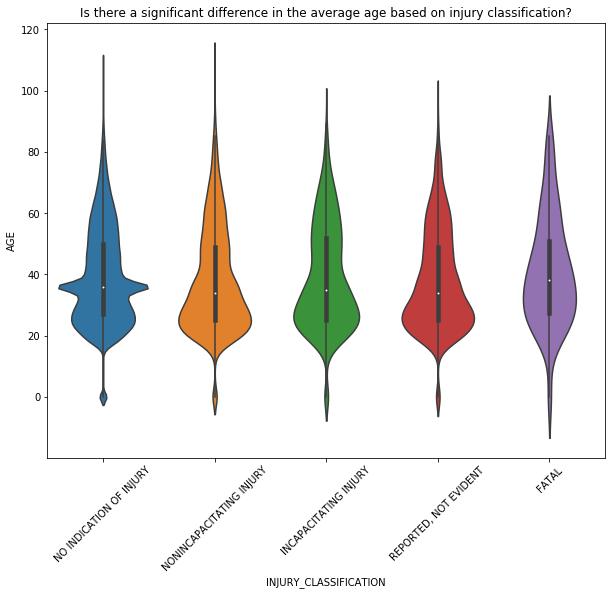

In [6]:
#Plotting violin chart
violin, ax = plt.subplots(figsize=(10,8))
sns.violinplot(y=result['AGE'], x=result['INJURY_CLASSIFICATION'], data=result)
ax.set(title='Is there a significant difference in the average age based on injury classification?')
plt.xticks(rotation=45)
violin.savefig('violin.png', bbox_inches='tight');


In [7]:
#creating a table to compare distribution of age and the injury class
no_indication = eda[eda['INJURY_CLASSIFICATION']=='NO INDICATION OF INJURY']
non_incapacitating = eda[eda['INJURY_CLASSIFICATION']=='NONINCAPACITATING INJURY']
reported = eda[eda['INJURY_CLASSIFICATION']=='REPORTED, NOT EVIDENT']
incapacitating = eda[eda['INJURY_CLASSIFICATION']=='INCAPACITATING INJURY']
fatal = eda[eda['INJURY_CLASSIFICATION']=='FATAL']
injury_bac = pd.DataFrame(columns=['NO INDICATION OF INJURY','NONINCAPACITATING INJURY','REPORTED, NOT EVIDENT','INCAPACITATING INJURY','FATAL'])
injury_bac['NO INDICATION OF INJURY']=no_indication.groupby('AGE')['AGE'].count()
injury_bac['NONINCAPACITATING INJURY']=non_incapacitating.groupby('AGE')['AGE'].count()
injury_bac['REPORTED, NOT EVIDENT']=reported.groupby('AGE')['AGE'].count()
injury_bac['INCAPACITATING INJURY']=incapacitating.groupby('AGE')['AGE'].count()
injury_bac['FATAL']=fatal.groupby('AGE')['AGE'].count()
injury_bac.fillna(0,inplace=True)
injury_bac

,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT",INCAPACITATING INJURY,FATAL
AGE,,,,,
0,2403,97.0,45.0,25.0,3.0
1,7,0.0,0.0,0.0,0.0
2,14,1.0,0.0,0.0,0.0
3,7,1.0,0.0,1.0,0.0
4,11,0.0,1.0,0.0,0.0
5,2,0.0,0.0,0.0,0.0
6,5,1.0,0.0,0.0,0.0
7,3,1.0,0.0,0.0,0.0
8,5,1.0,0.0,0.0,0.0


In [8]:
injury_bac.reset_index(inplace=True)

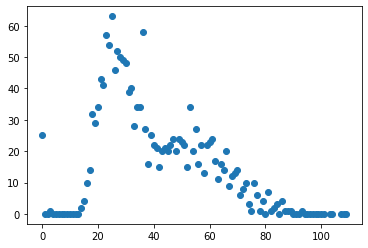

In [9]:
#distribution of age and injury that is incapacitating  
plt.scatter(injury_bac['AGE'], injury_bac['INCAPACITATING INJURY'])
plt.show();

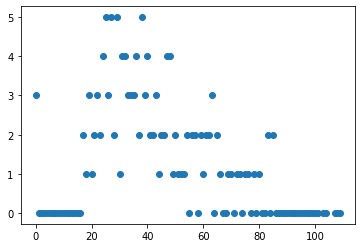

In [10]:
#distribution of age and injury that is fatal  
plt.scatter(injury_bac['AGE'], injury_bac['FATAL'])
plt.show();

People between their 20's to 40 are most likely to get an incapitating injury or fatal.

# Chi Squared

Is the type of injury independent of the crash type?
- H0: injury is independent of crash type
- HA: injury is not independent of crash type

In [11]:
#creating a table to compare distribution of crash type and the injury class
no_indication = eda[eda['INJURY_CLASSIFICATION']=='NO INDICATION OF INJURY']
non_incapacitating = eda[eda['INJURY_CLASSIFICATION']=='NONINCAPACITATING INJURY']
reported = eda[eda['INJURY_CLASSIFICATION']=='REPORTED, NOT EVIDENT']
incapacitating = eda[eda['INJURY_CLASSIFICATION']=='INCAPACITATING INJURY']
fatal = eda[eda['INJURY_CLASSIFICATION']=='FATAL']
injury_bac = pd.DataFrame(columns=['NO INDICATION OF INJURY','NONINCAPACITATING INJURY','REPORTED, NOT EVIDENT','INCAPACITATING INJURY','FATAL'])
injury_bac['NO INDICATION OF INJURY']=no_indication.groupby('FIRST_CRASH_TYPE')['FIRST_CRASH_TYPE'].count()
injury_bac['NONINCAPACITATING INJURY']=non_incapacitating.groupby('FIRST_CRASH_TYPE')['FIRST_CRASH_TYPE'].count()
injury_bac['REPORTED, NOT EVIDENT']=reported.groupby('FIRST_CRASH_TYPE')['FIRST_CRASH_TYPE'].count()
injury_bac['INCAPACITATING INJURY']=incapacitating.groupby('FIRST_CRASH_TYPE')['FIRST_CRASH_TYPE'].count()
injury_bac['FATAL']=fatal.groupby('FIRST_CRASH_TYPE')['FIRST_CRASH_TYPE'].count()
injury_bac.fillna(0,inplace=True)
injury_bac

,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT",INCAPACITATING INJURY,FATAL
FIRST_CRASH_TYPE,,,,,
ANGLE,28166,1498,900.0,275.0,6.0
ANIMAL,188,5,1.0,1.0,0.0
FIXED OBJECT,10441,1262,373.0,364.0,65.0
HEAD ON,1840,207,64.0,67.0,8.0
OTHER NONCOLLISION,1061,65,16.0,22.0,2.0
OTHER OBJECT,2414,114,43.0,51.0,2.0
OVERTURNED,80,45,12.0,11.0,0.0
PARKED MOTOR VEHICLE,31601,1014,334.0,228.0,29.0
PEDALCYCLIST,2245,17,8.0,7.0,0.0


In [12]:
from scipy import stats
from scipy.stats import chi2_contingency
stat,p,dof,expected = stats.chi2_contingency(injury_bac)
prob=.95
critical = stats.chi2.ppf(prob,dof)
critical,stat

(88.25016442187412, 8326.246167775733)

We reject the null. We further explored and the most leathel car accidents are ones that you run into a fixed object

# Chi Squared

Is airbag deployment independent of injury classification?

Ho: It is independent
Ha: It is not 

In [64]:
#creating a table to compare distribution of crash type and the injury class
no_indication = eda[eda['INJURY_CLASSIFICATION']=='NO INDICATION OF INJURY']
non_incapacitating = eda[eda['INJURY_CLASSIFICATION']=='NONINCAPACITATING INJURY']
reported = eda[eda['INJURY_CLASSIFICATION']=='REPORTED, NOT EVIDENT']
incapacitating = eda[eda['INJURY_CLASSIFICATION']=='INCAPACITATING INJURY']
fatal = eda[eda['INJURY_CLASSIFICATION']=='FATAL']
injury_bac = pd.DataFrame(columns=['NO INDICATION OF INJURY','NONINCAPACITATING INJURY','REPORTED, NOT EVIDENT','INCAPACITATING INJURY','FATAL'])
injury_bac['NO INDICATION OF INJURY']=no_indication.groupby('AIRBAG_DEPLOYED')['AIRBAG_DEPLOYED'].count()
injury_bac['NONINCAPACITATING INJURY']=non_incapacitating.groupby('AIRBAG_DEPLOYED')['AIRBAG_DEPLOYED'].count()
injury_bac['REPORTED, NOT EVIDENT']=reported.groupby('AIRBAG_DEPLOYED')['AIRBAG_DEPLOYED'].count()
injury_bac['INCAPACITATING INJURY']=incapacitating.groupby('AIRBAG_DEPLOYED')['AIRBAG_DEPLOYED'].count()
injury_bac['FATAL']=fatal.groupby('AIRBAG_DEPLOYED')['AIRBAG_DEPLOYED'].count()
injury_bac.fillna(0,inplace=True)
injury_bac

,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT",INCAPACITATING INJURY,FATAL
AIRBAG_DEPLOYED,,,,,
"DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)",79,14,6,9,0.0
"DEPLOYED, COMBINATION",2983,1372,416,330,28.0
"DEPLOYED, FRONT",7387,2203,817,474,41.0
"DEPLOYED, SIDE",1505,276,153,41,4.0
DEPLOYMENT UNKNOWN,17481,376,185,81,12.0
DID NOT DEPLOY,175745,2604,1822,474,36.0
NOT APPLICABLE,29913,603,271,212,13.0


In [65]:
from scipy import stats
from scipy.stats import chi2_contingency
stat,p,dof,expected = stats.chi2_contingency(injury_bac)
prob=.95
critical = stats.chi2.ppf(prob,dof)
critical,stat

(36.41502850180731, 35652.82054737133)

We reject the null. Therefore, airbag deployment is not independent of injury classfication. 

We did further eda and found that in fatal and incapacitating injury car accidents there were twice as many air bag deployment. 

## Feature engineering

Rating primary cause of the crash and creating a risk percentage

In [13]:
result['prim']=result['PRIM_CONTRIBUTORY_CAUSE'].map({'UNABLE TO DETERMINE': 3,'FOLLOWING TOO CLOSELY': 3,'FAILING TO YIELD RIGHT-OF-WAY': 4,
'IMPROPER BACKING': 1.5,
'FAILING TO REDUCE SPEED TO AVOID CRASH':3.5 ,
'IMPROPER OVERTAKING/PASSING': 3,
'WEATHER': 3,
'NOT APPLICABLE': 3  ,
'DISREGARDING STOP SIGN': 2 ,
'DISTRACTION - FROM INSIDE VEHICLE': 2,
'PHYSICAL CONDITION OF DRIVER': 5,
'IMPROPER LANE USAGE': 3,
'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)': 2,
'EXCEEDING SAFE SPEED FOR CONDITIONS': 3.5,
'IMPROPER TURNING/NO SIGNAL': 3,
'EQUIPMENT - VEHICLE CONDITION': 2.5,
'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 2.5,
'DRIVING ON WRONG SIDE/WRONG WAY': 4,
'DISREGARDING TRAFFIC SIGNALS': 4.5,
'EXCEEDING AUTHORIZED SPEED LIMIT': 4,
'DISREGARDING ROAD MARKINGS': 1,
'ROAD ENGINEERING/SURFACE/MARKING DEFECTS': 2.5,
'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST': 1,
'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 4,
'TEXTING': 2,
'DISTRACTION - FROM OUTSIDE VEHICLE': 2,
'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 4.5,
'ANIMAL': 1,
'ROAD CONSTRUCTION/MAINTENANCE': 2,
'CELL PHONE USE OTHER THAN TEXTING': 1,
'DISREGARDING OTHER TRAFFIC SIGNS': 1.5,
'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 1,
'TURNING RIGHT ON RED': 2,
'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)': 1,
'PASSING STOPPED SCHOOL BUS':1 ,
'DISREGARDING YIELD SIGN': 1,
'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT': .5,
'BICYCLE ADVANCING LEGALLY ON RED LIGHT': .5,
'RELATED TO BUS STOP': 1,
'OBSTRUCTED CROSSWALKS': 1})

In [14]:
result['aggregate_rating'] = result['prim'].map(lambda x: x*2)
result['prim_rating'] = result['aggregate_rating'].map(lambda x: x/2)
result['risk_rating']= result['aggregate_rating'].map(lambda x: x/10)
result.drop(['aggregate_rating','prim_rating'],axis=1,inplace=True)

## Reassigning categorical with numbers

## INJURY_CLASSIFICATION
- NO INDICATION OF INJURY:0
- NONINCAPACITATING INJURY:2
- REPORTED, NOT EVIDENT:1
- INCAPACITATING INJURY:3
- FATAL:4

- 0 : No injury 
- 1 : Minor injury
- 2 : Major injury



Seperating injury classification into no, minor, and major injury

In [15]:
result['INJURY_CLASSIFICATION']=result['INJURY_CLASSIFICATION'].map({'NO INDICATION OF INJURY':0,
 'NONINCAPACITATING INJURY':1,
 'REPORTED, NOT EVIDENT':1,
 'INCAPACITATING INJURY':2,
 'FATAL':2})

## Dummy Variables

In [16]:
dummy_columns = ['PERSON_TYPE','SEX','SAFETY_EQUIPMENT','AIRBAG_DEPLOYED','EJECTION','DRIVER_ACTION','DRIVER_VISION','PHYSICAL_CONDITION','BAC_RESULT','TRAFFIC_CONTROL_DEVICE','DEVICE_CONDITION',
 'WEATHER_CONDITION',
 'LIGHTING_CONDITION',
 'FIRST_CRASH_TYPE',
 'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','ROAD_DEFECT',
 'CRASH_TYPE',
 'DAMAGE',
 'PRIM_CONTRIBUTORY_CAUSE',
 'SEC_CONTRIBUTORY_CAUSE']
dummy = pd.get_dummies(result, columns=['PERSON_TYPE','SEX','SAFETY_EQUIPMENT','AIRBAG_DEPLOYED','EJECTION','DRIVER_ACTION','DRIVER_VISION','PHYSICAL_CONDITION','BAC_RESULT','TRAFFIC_CONTROL_DEVICE','DEVICE_CONDITION',
 'WEATHER_CONDITION',
 'LIGHTING_CONDITION',
 'FIRST_CRASH_TYPE',
 'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','ROAD_DEFECT',
 'CRASH_TYPE',
 'DAMAGE',
 'PRIM_CONTRIBUTORY_CAUSE',
 'SEC_CONTRIBUTORY_CAUSE'],drop_first=True)

## Feature importance

In [17]:
X = dummy.drop(['INJURY_CLASSIFICATION'],axis=1)
y=dummy['INJURY_CLASSIFICATION']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 )
rfc1 = RandomForestClassifier(random_state=1, class_weight='balanced',n_jobs=-1,verbose=True)
rfc1.fit(X_train,y_train)
y_pred_test_rfc1 = rfc1.predict(X_test)

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=1, verbose=True, warm_start=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


# Modeling

There is a class imbalance in our target variable. No injury had the most by few hundred thousand. (No injury, minor injury, major injury).

We decided to prioritize our F-1 Macro score because the higher it is the better capture between precision and recall balance between all target variables.

## Decision Tree: Smote

In [18]:
X = dummy.drop(['INJURY_CLASSIFICATION'],axis=1)
y=dummy['INJURY_CLASSIFICATION']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 )

In [19]:
from imblearn.over_sampling import SMOTE

In [20]:
sm = SMOTE(sampling_strategy= 'not minority', random_state=23)
X_train, y_train = sm.fit_sample(X_train, y_train)
dtc = DecisionTreeClassifier(random_state=1, class_weight = 'balanced')
dtc = dtc.fit(X_train,y_train)
# y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

In [21]:
print("Macro Testing F1 Score:",metrics.f1_score(y_test, y_pred_test, 
                                            average='macro',labels = [0,1,2]))
print("Micro Testing F1 Score:",metrics.f1_score(y_test, y_pred_test, 
                                            average='micro',labels = [0,1,2]))
print("Testing Accuracy Score:",metrics.accuracy_score(y_test, y_pred_test))


Macro Testing F1 Score: 0.4389602883491634
Micro Testing F1 Score: 0.9223898052183732
Testing Accuracy Score: 0.9223898052183732


## Random Forest Classifier: Smote

In [22]:
X = dummy.drop(['INJURY_CLASSIFICATION'],axis=1)
y=dummy['INJURY_CLASSIFICATION']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 )
sm = SMOTE(sampling_strategy= 'all', random_state=23,n_jobs=-1)
X_train, y_train = sm.fit_sample(X_train, y_train)


In [23]:
rfc1 = RandomForestClassifier(random_state=1, class_weight='balanced',n_jobs=-1,verbose=True)
rfc1.fit(X_train,y_train)
y_pred_test_rfc1 = rfc1.predict(X_test)

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.4s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=1, verbose=True, warm_start=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


In [24]:
print("Macro Testing F1 Score:",metrics.f1_score(y_test, y_pred_test_rfc1, 
                                            average='macro',labels = [0,1,2]))
print("Micro Testing F1 Score:",metrics.f1_score(y_test, y_pred_test_rfc1, 
                                            average='micro',labels = [0,1,2]))
print("Testing Accuracy Score:",metrics.accuracy_score(y_test, y_pred_test_rfc1))

Macro Testing F1 Score: 0.42693723143918993
Micro Testing F1 Score: 0.948300197604549
Testing Accuracy Score: 0.948300197604549


In [25]:
rfc1.feature_importances_
np.sort(rfc1.feature_importances_)[-15:]

array([2.69440165e-02, 1.23631563e-02, 2.30906511e-02, 1.77178184e-02,
       2.03695066e-02, 2.26471255e-02, 2.67218501e-02, 1.43173460e-05,
       2.17816444e-06, 1.63939435e-02, 3.07281292e-03, 1.46248803e-03,
       1.69721617e-03, 1.41725672e-04, 2.65438776e-03, 2.72569469e-02,
       8.91936233e-08, 1.21610050e-02, 0.00000000e+00, 1.28318719e-02,
       2.98818154e-02, 2.77950898e-03, 7.58586553e-03, 3.03387258e-02,
       7.76502381e-03, 6.42375312e-04, 7.73501685e-03, 2.93240663e-03,
       3.08590350e-03, 3.53226367e-03, 2.84911867e-04, 6.19427505e-04,
       1.17046438e-02, 4.17333041e-03, 6.77378157e-04, 2.12973629e-03,
       1.72869144e-04, 1.38689587e-03, 2.78949681e-03, 4.76104089e-06,
       5.04729100e-03, 7.82627558e-03, 1.05024584e-04, 0.00000000e+00,
       2.09146812e-04, 4.19155212e-03, 8.62525322e-03, 1.16722448e-03,
       2.44894616e-04, 3.95446498e-06, 1.63703444e-05, 1.71307009e-06,
       1.76022639e-05, 1.01881076e-03, 1.21154963e-02, 1.48560520e-03,
      

array([0.01771782, 0.01839344, 0.01978334, 0.02036951, 0.02264713,
       0.02309065, 0.02672185, 0.02679005, 0.02694402, 0.02725695,
       0.02789707, 0.02988182, 0.03033873, 0.04426831, 0.08481716])

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.twilight):
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.yticks(np.arange(0, 3, step=1.2))
    plt.xticks(np.arange(0, 3, step=1.2))

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="top",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[46649   359     6]
 [ 1823   368    25]
 [  261    90    13]]


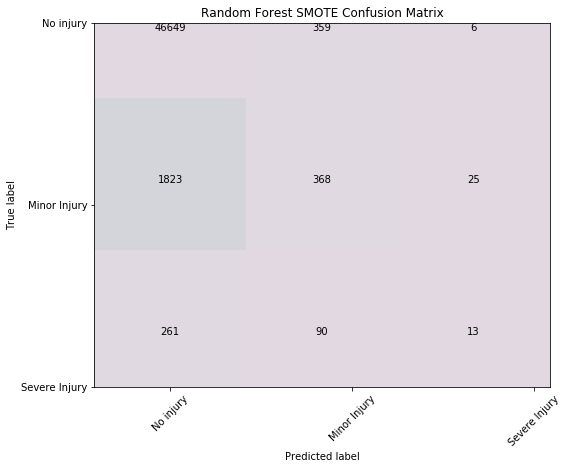

In [27]:
cnf_matrix = confusion_matrix(y_test, y_pred_test_rfc1,labels=[0,1,2])
#np.set_printoptions(precision=2)

confusion, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['No injury','Minor Injury','Severe Injury'],
                      title='')
ax.set(title='Random Forest SMOTE Confusion Matrix')
confusion.savefig('confusion_smote.png', bbox_inches='tight');

# Ranking importances for primary cause of the crash


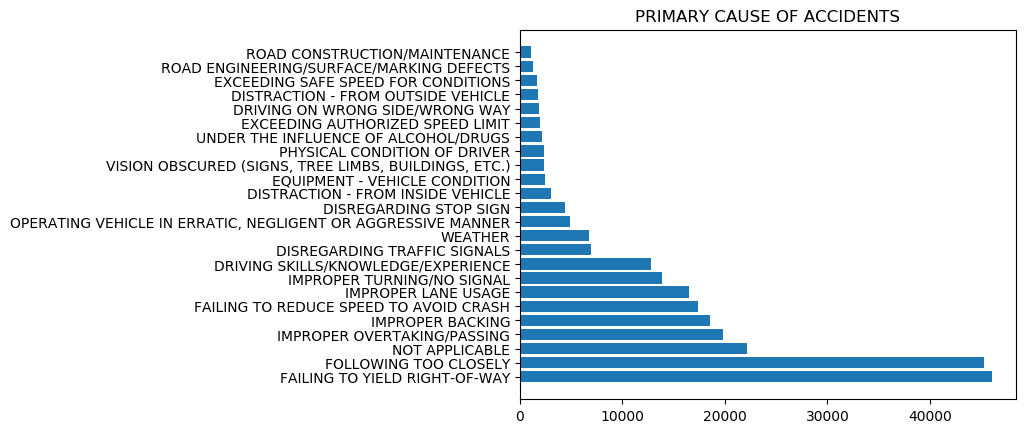

In [28]:
plt.rcdefaults()
fig, ax = plt.subplots()
people = (['FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY' ,'NOT APPLICABLE'
,'IMPROPER OVERTAKING/PASSING'
,'IMPROPER BACKING'
,'FAILING TO REDUCE SPEED TO AVOID CRASH'
,'IMPROPER LANE USAGE'
,'IMPROPER TURNING/NO SIGNAL'
,'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE'
,'DISREGARDING TRAFFIC SIGNALS'
,'WEATHER'
,'OPERATING VEHICLE IN ERRATIC, NEGLIGENT OR AGGRESSIVE MANNER'
,'DISREGARDING STOP SIGN'
,'DISTRACTION - FROM INSIDE VEHICLE'
,'EQUIPMENT - VEHICLE CONDITION'
,'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'
,'PHYSICAL CONDITION OF DRIVER'
,'UNDER THE INFLUENCE OF ALCOHOL/DRUGS'
,'EXCEEDING AUTHORIZED SPEED LIMIT'
,'DRIVING ON WRONG SIDE/WRONG WAY'
,'DISTRACTION - FROM OUTSIDE VEHICLE'
,'EXCEEDING SAFE SPEED FOR CONDITIONS'
,'ROAD ENGINEERING/SURFACE/MARKING DEFECTS'
,'ROAD CONSTRUCTION/MAINTENANCE'                                                         ])
y_pos = np.arange(len(people))
performance =  [46098
                    ,                                           45262
                     ,                                                 22140
                      ,                                  19847
                       ,                                            18523
                        ,                     17335
                         ,                                         16522
                          ,                                13855,
                                                  12808,
                                                        6971,
                 6740,
     4902,
                                                               4356,
                                                    2990
,                                                      2449
,                              2369
,                                                        2335
,                   2148
,                                                      1972
,                                                       1816
,                                                  1803
,                                                   1682
,                                              1273
,                                                         1068]
ax.barh( y_pos, performance )
ax.set_yticklabels(people)
ax.set_yticks(y_pos)
ax.set_title('PRIMARY CAUSE OF ACCIDENTS')
plt.show()
fig.savefig('fig.png', bbox_inches='tight');

## Age plotted against risk rating

<Figure size 2000x1000 with 0 Axes>

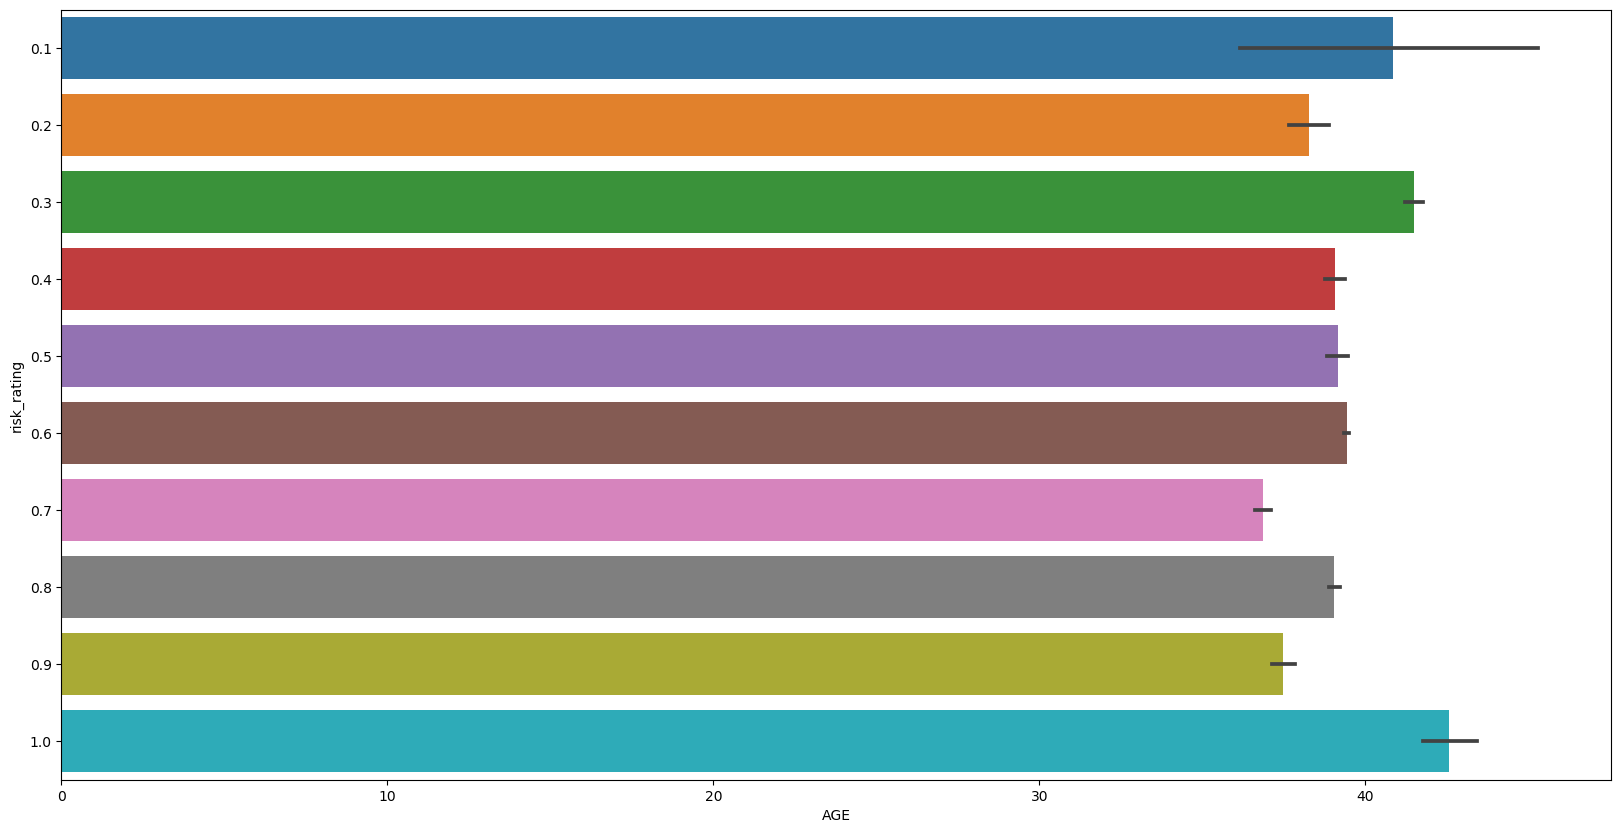

In [29]:
plt.figure(figsize=(20,10))
sns.barplot(y=result['risk_rating'], x = result['AGE'], orient='h',data=result)
#plt.xticks(rotation=90);


## At what age are you most risk exposed to each classification of injury?

In [30]:
graphing=result.groupby('INJURY_CLASSIFICATION').apply(lambda x:x.sort_values(by=['INJURY_CLASSIFICATION'],
                                                                    ascending=True))

In [31]:
graph_data=graphing[-1755: ]
graph_data['AGE']
graph_data1=graphing[0:235093]
graph_data1['AGE']
graph_data2=graphing[235093:246211]
graph_data2['AGE']

INJURY_CLASSIFICATION        
2                      706       20
                       626834    23
                       626522    25
                       624929    21
                       623607    35
                                 ..
                       323501    27
                       323472    48
                       322756    20
                       327924    63
                       897313    26
Name: AGE, Length: 1755, dtype: int64

INJURY_CLASSIFICATION        
0                      0         36
                       594176    38
                       594178    30
                       594181    37
                       594189    20
                                 ..
                       296025    82
                       296029    64
                       296033    25
                       296049    47
                       897403    36
Name: AGE, Length: 235093, dtype: int64

INJURY_CLASSIFICATION        
1                      164       36
                       625996    20
                       626021    48
                       626078    61
                       626089    47
                                 ..
                       339324    48
                       339398    49
                       339419    69
                       338599    93
                       897334    33
Name: AGE, Length: 11118, dtype: int64

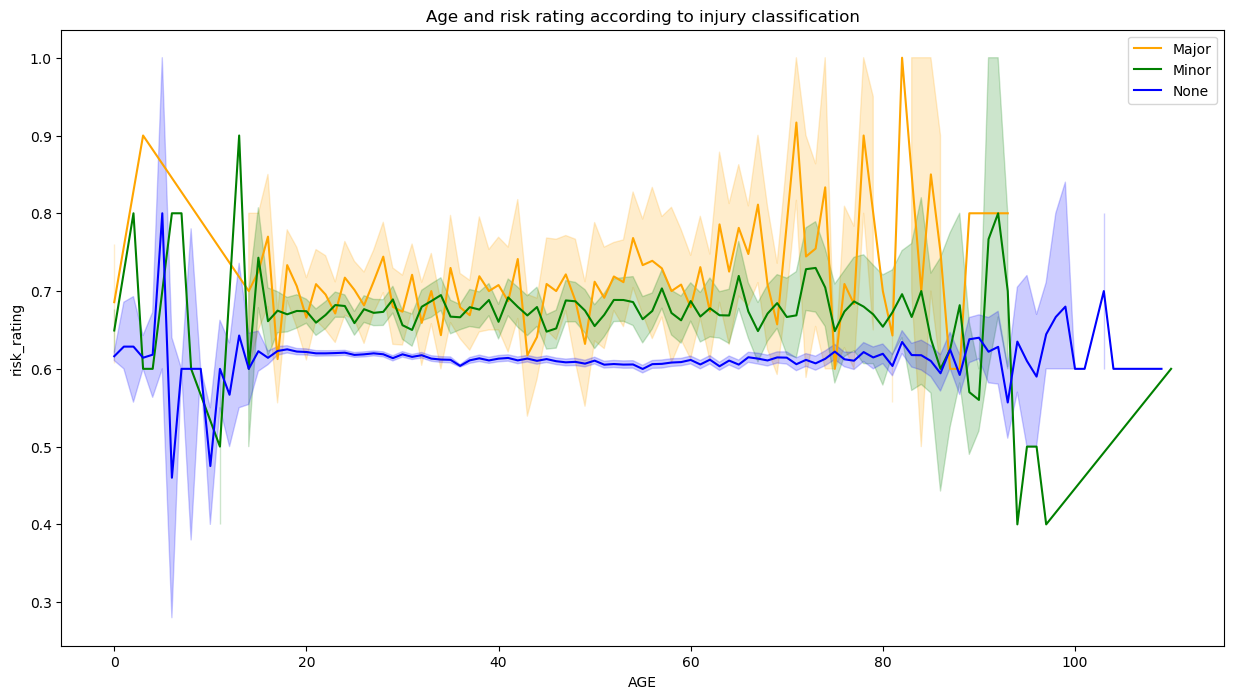

In [32]:
line, ax = plt.subplots(figsize=(15,8))
sns.lineplot(y=graph_data['risk_rating'], x = graph_data['AGE'], data=result, color = 'orange', label='Major')
sns.lineplot(y=graph_data2['risk_rating'], x = graph_data2['AGE'], data=result, color ='green', label = 'Minor')
sns.lineplot(y=graph_data1['risk_rating'], x = graph_data1['AGE'], data=result, color = 'blue', label = 'None')
ax.set(title='Age and risk rating according to injury classification')
line.savefig('line.png', bbox_inches='tight');

## GridSearch: Smote

The parameters that we tuned did not help our model F-1 score. 

In [33]:
# X = dummy.drop(['INJURY_CLASSIFICATION'],axis=1)
# y=dummy['INJURY_CLASSIFICATION']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 )
# sm = SMOTE(sampling_strategy= 'all', random_state=23,n_jobs=-1)
# X_train, y_train = sm.fit_sample(X_train, y_train)
# parameters ={'criterion': ['entropy','gini'],'max_depth':range(1,10),'max_leaf_nodes':range(3,15),'n_estimators' : [100,200,'warn']}
# rfc_grid = RandomForestClassifier(random_state=1, class_weight='balanced',n_jobs=-1,verbose=True)
# grid_tree = GridSearchCV(rfc_grid, parameters, cv=5, n_jobs =-1)
# grid_tree.fit(X_train,y_train)

# print(grid_tree.best_estimator_)
# y_pred = grid_tree.best_estimator_.predict(X_test)
# print("Testing F1 Score:",metrics.f1_score(y_test, y_pred, 
#                                             average='micro'))

In [34]:
len(result.columns)

29

## Calculating if the sklearn model evaluation matrics matches with hand calculations

In [35]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(y_test, y_pred_test_rfc1)
matrix

array([[46649,   359,     6],
       [ 1823,   368,    25],
       [  261,    90,    13]])

## Micro F-1

In [36]:
TP0 = matrix[0][0] 
TP1 = matrix[1][1] 
TP2 = matrix[2][2] 
TP =TP0+TP1+TP2
FP0 = matrix[1][0]+matrix[2][0] 
FP1 = matrix[0][1] + matrix[2][1] 
FP2 = matrix[0][2] + matrix[1][2] 
FP = FP0+FP1+FP2
TN0 = matrix[1][1] + matrix[2][1] + matrix[1][2] + matrix[2][2] 
TN1 = matrix[0][0] +matrix[2][0] + matrix[2][0] + matrix[2][2] 
TN2 = matrix[0][0] + matrix[1][0] + matrix[0][1] + matrix[1][1] 
TN = TN0+TN1+TN2
FN0 = matrix[0][1] + matrix[0][2] 
FN1 =matrix[1][0] + matrix[1][2] 
FN2 = matrix[2][0] + matrix[2][1] 
FN= FN0+FN1+FN2

In [37]:
P =TP/ (TP+FP)
P

0.948300197604549

In [38]:
R = TP/(TP+FN)
R

0.948300197604549

In [39]:
F1 = 2*((P*R)/(P+R))
F1

0.948300197604549

## Macro F-1 Score

In [40]:
TP0 = matrix[0][0] 
TP1 = matrix[1][1] 
TP2 = matrix[2][2] 
TP =TP0+TP1+TP2
FP0 = matrix[1][0]+matrix[2][0] 
FP1 = matrix[0][1] + matrix[2][1] 
FP2 = matrix[0][2] + matrix[1][2] 
FP = FP0+FP1+FP2
TN0 = matrix[1][1] + matrix[2][1] + matrix[1][2] + matrix[2][2] 
TN1 = matrix[0][0] +matrix[2][0] + matrix[2][0] + matrix[2][2] 
TN2 = matrix[0][0] + matrix[1][0] + matrix[0][1] + matrix[1][1] 
TN = TN0+TN1+TN2
FN0 = matrix[0][1] + matrix[0][2] 
FN1 =matrix[1][0] + matrix[1][2] 
FN2 = matrix[2][0] + matrix[2][1] 
FN= FN0+FN1+FN2

In [41]:
((TP0/(TP0+FP0))+(TP1/(TP1+FP1))+(TP2/(TP2+FP2)))/3

0.5677064372110614

## Sampling to make even 

Need to up and down sample the classifications to 20,000 observations

No injury was severly higher in observations than major and minor injury

In [42]:
downsample1 = dummy[(dummy['INJURY_CLASSIFICATION']==1)|(dummy['INJURY_CLASSIFICATION']==0)]
downsample2 = dummy[(dummy['INJURY_CLASSIFICATION']==2)|(dummy['INJURY_CLASSIFICATION']==1)]
fatalinjury = downsample2[downsample2.INJURY_CLASSIFICATION==2]
majorinjury = downsample2[downsample2.INJURY_CLASSIFICATION==1]
minorinjury = downsample1[downsample1.INJURY_CLASSIFICATION==0]

In [43]:
upsample1 = resample(fatalinjury,
                          replace=True, # sample with replacement
                          n_samples=20000, # match number in majority class
                          random_state=23) # reproducible results




In [44]:
downsampled = resample(minorinjury,
                                replace = False, # sample without replacement
                                n_samples = 20000, # match minority n
                                random_state = 23) # reproducible results

In [45]:
midsample = resample(majorinjury,
                                replace = True, # sample without replacement
                                n_samples = 20000, # match minority n
                                random_state = 23)

In [46]:
sampling = pd.concat([upsample1, downsampled,midsample])

## Random Forest: New class balance 

In [47]:
X = dummy.drop(['INJURY_CLASSIFICATION'],axis=1)
y=dummy['INJURY_CLASSIFICATION']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 )

In [48]:
X_train = sampling.drop(['INJURY_CLASSIFICATION'],axis=1)
y_train = sampling['INJURY_CLASSIFICATION']
rfc1 = RandomForestClassifier(random_state=1, class_weight='balanced',n_jobs=-1,verbose=True)
rfc1 = rfc1.fit(X_train,y_train)
y_pred_test_rfc1 = rfc1.predict(X_test)
print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test_rfc1, 
                                            average='macro',labels = [0,1,2]))
print("Testing Accuracy Score:",metrics.accuracy_score(y_test, y_pred_test_rfc1))

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Testing F1 Score: 0.7416486968544231
Testing Accuracy Score: 0.884219865306287


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


Confusion matrix, without normalization
[[41360  5549   105]
 [   74  2128    14]
 [    0     0   364]]


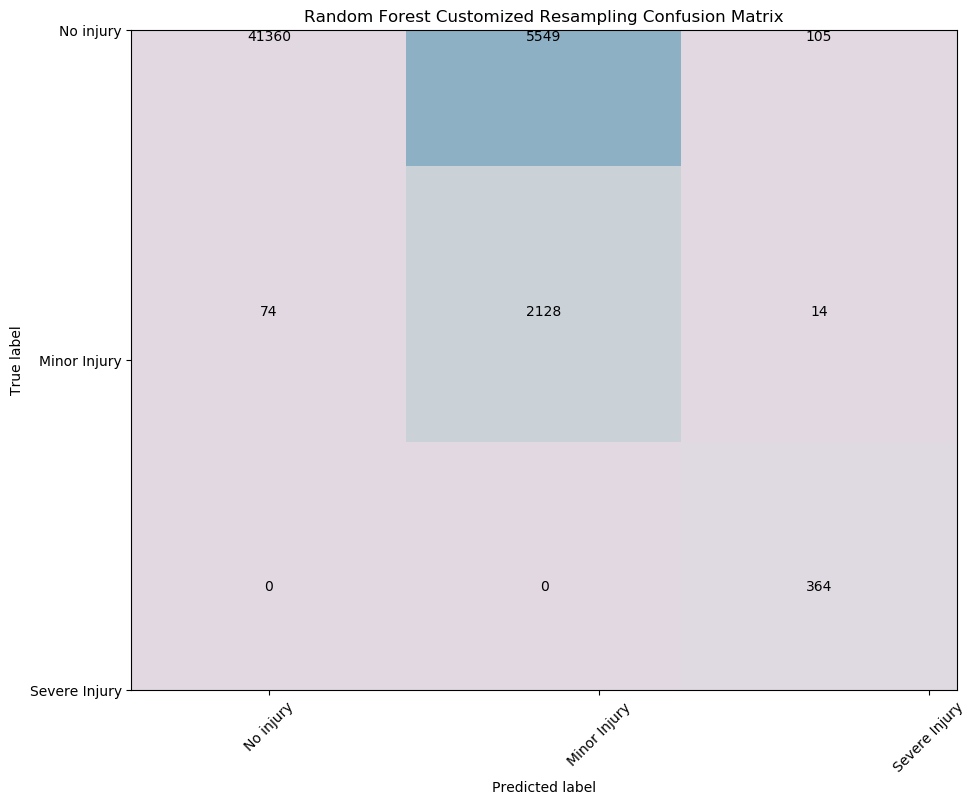

In [49]:
cnf_matrix = confusion_matrix(y_test, y_pred_test_rfc1,labels=[0,1,2])
#np.set_printoptions(precision=2)
confusion_balance, ax = plt.subplots(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=['No injury','Minor Injury','Severe Injury'],
                      title='')
ax.set(title='Random Forest Customized Resampling Confusion Matrix')
confusion_balance.savefig('Random_Forest_with_feature_model.png', bbox_inches='tight');

## Decision Tree: customized class balance

In [50]:
dtc = DecisionTreeClassifier( criterion='gini', class_weight='balanced')
dtc.fit(X_train, y_train)
y_preds=dtc.predict(X_test)
print("Testing F1 Score:", metrics.f1_score(y_test, y_preds, average='macro'))
print("Testing Accuracy Score:", metrics.accuracy_score(y_test, y_preds))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Testing F1 Score: 0.6152094150876348
Testing Accuracy Score: 0.8791789329354357


## KNN: customized class balance

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6, weights='distance', algorithm='kd_tree', n_jobs=-1)
knn.fit(X_train, y_train)
knn_preds=knn.predict(X_test)
print("Testing F1 Score:", metrics.f1_score(y_test, knn_preds, average='macro'))
print("Testing Accuracy Score:", metrics.accuracy_score(y_test, knn_preds))

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                     weights='distance')

Testing F1 Score: 0.433409080002718
Testing Accuracy Score: 0.7318022341412268


## Voting Classifier: customized class balance

In [52]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
                estimators=[('r_forest', rfc1), ('knneighbors', knn), ('decisiontree', dtc)], 
                voting='soft')
voting_clf.fit(X_train, y_train)
vc_preds = voting_clf.predict(X_test)
print(metrics.f1_score(y_test, vc_preds, average='macro'))
print("Testing Accuracy Score:", metrics.accuracy_score(y_test, vc_preds))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


VotingClassifier(estimators=[('r_forest',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=10, n_jobs=-1,
                                                     o

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


0.6647452106224926
Testing Accuracy Score: 0.882526112029681


# Modeling without the feature: Random Forest customized class balance (Best model)

In [53]:
dummy.drop('risk_rating',axis=1,inplace=True)
sampling.drop('risk_rating',axis=1,inplace=True)

In [54]:
X = dummy.drop(['INJURY_CLASSIFICATION'],axis=1)
y=dummy['INJURY_CLASSIFICATION']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 )
X_train = sampling.drop(['INJURY_CLASSIFICATION'],axis=1)
y_train = sampling['INJURY_CLASSIFICATION']
rfc1 = RandomForestClassifier(random_state=1, class_weight='balanced',n_jobs=-1,verbose=True)
rfc1.fit(X_train,y_train)
y_pred_test_rfc1 = rfc1.predict(X_test)

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=1, verbose=True, warm_start=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


In [55]:
print("Macro Testing F1 Score:",metrics.f1_score(y_test, y_pred_test_rfc1, 
                                            average='macro',labels = [0,1,2]))
print("Micro Testing F1 Score:",metrics.f1_score(y_test, y_pred_test_rfc1, 
                                            average='micro',labels = [0,1,2]))
print("Testing Accuracy Score:",metrics.accuracy_score(y_test, y_pred_test_rfc1))


Macro Testing F1 Score: 0.7450879760352475
Micro Testing F1 Score: 0.8843811751421543
Testing Accuracy Score: 0.8843811751421543


Feature does not help our model

Confusion matrix, without normalization
[[41384  5541    89]
 [   86  2112    18]
 [    0     0   364]]


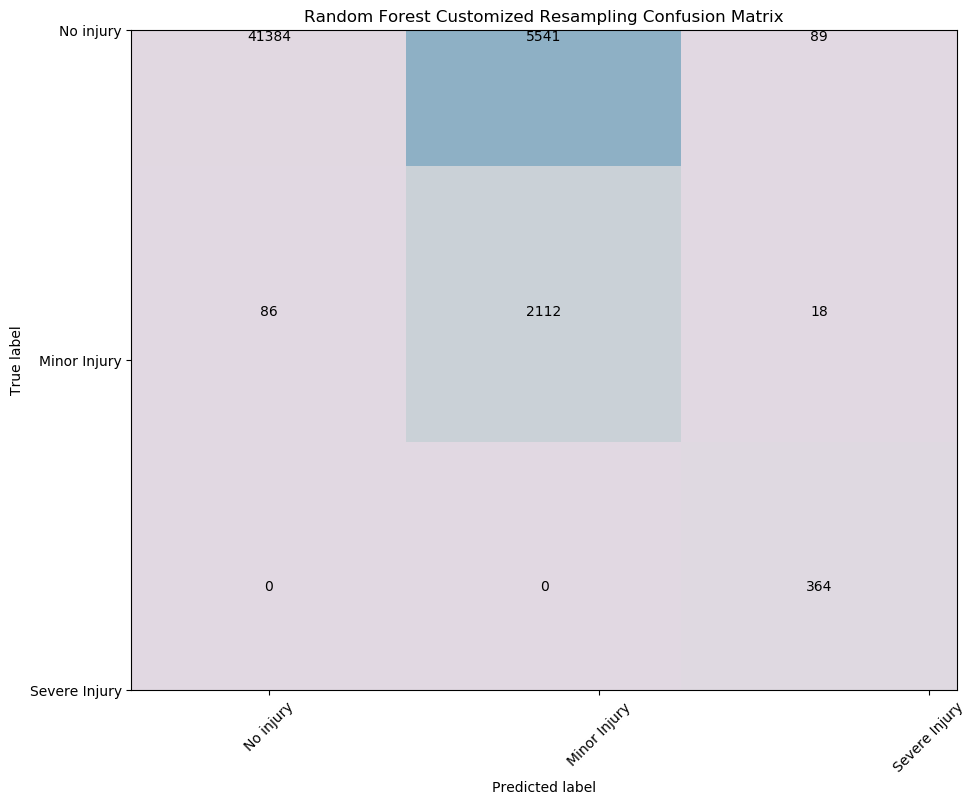

In [56]:
cnf_matrix = confusion_matrix(y_test, y_pred_test_rfc1,labels=[0,1,2])
#np.set_printoptions(precision=2)
best_model_confusion, ax = plt.subplots(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=['No injury','Minor Injury','Severe Injury'],
                      title='')
ax.set(title='Random Forest Customized Resampling Confusion Matrix')
best_model_confusion.savefig('best_model_confusion.png', bbox_inches='tight');

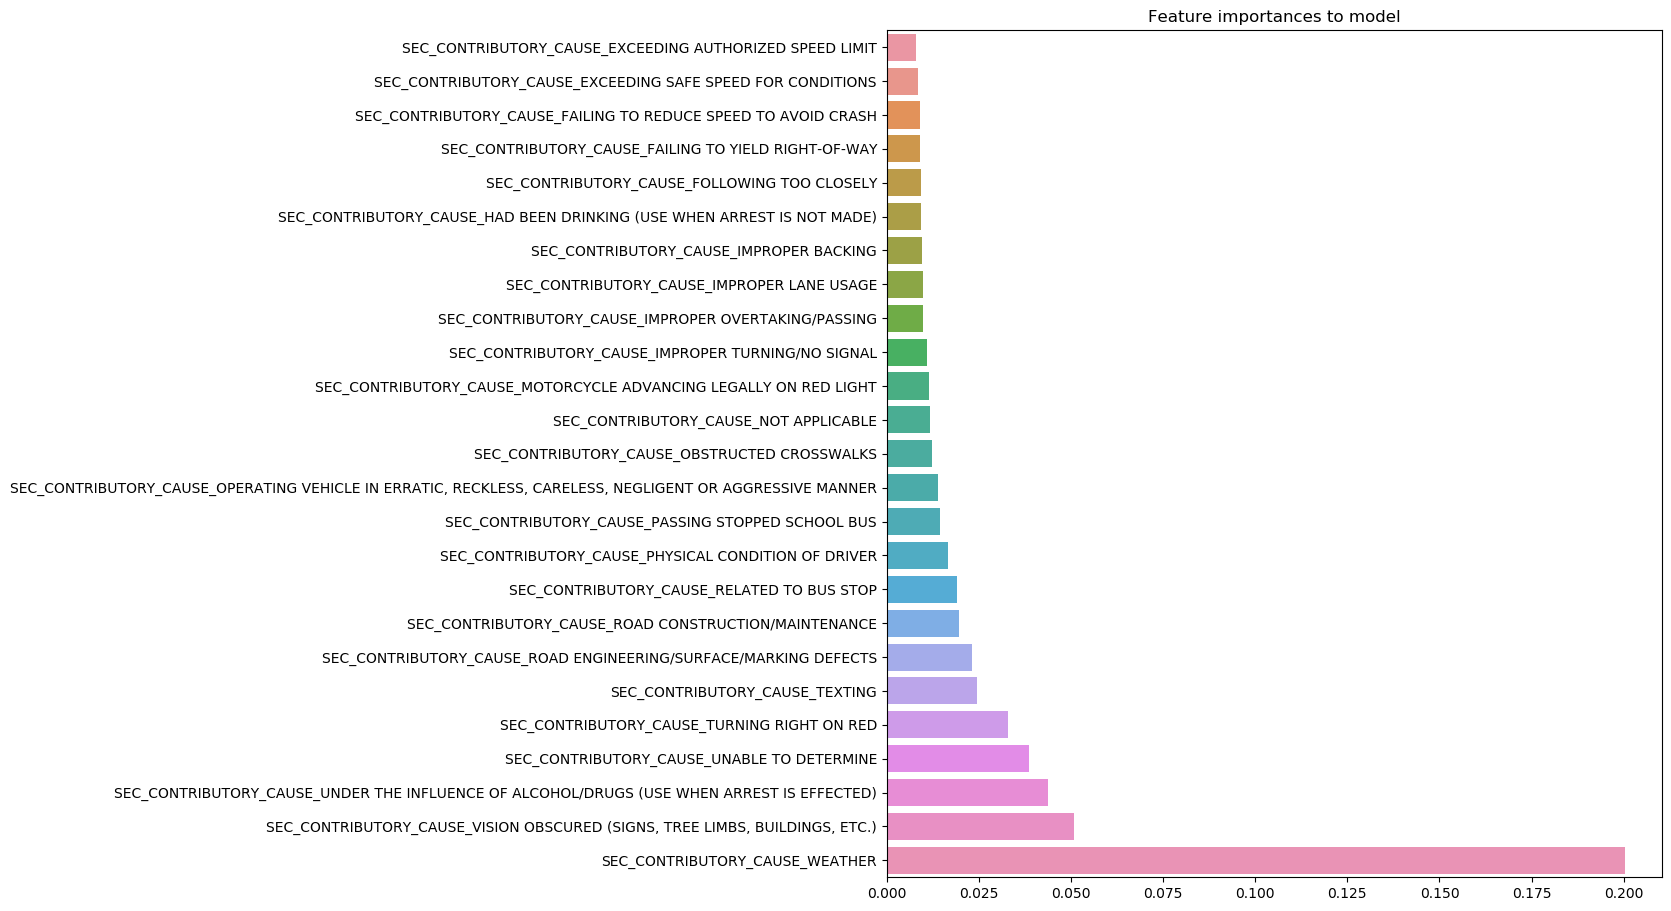

In [57]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    

features, ax = plt.subplots(figsize=(10,11))
sns.barplot( y=X_train.columns.values[-25: ], x=np.sort(rfc1.feature_importances_)[-25:], orient='h')
ax.set(title='Feature importances to model')
features.savefig('features.png', bbox_inches='tight');


# GridSearch modeling without the feature: Random Forest 


In [58]:
# X = dummy.drop(['INJURY_CLASSIFICATION'],axis=1)
# y=dummy['INJURY_CLASSIFICATION']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 )
# X_train = sampling.drop(['INJURY_CLASSIFICATION'],axis=1)
# y_train = sampling['INJURY_CLASSIFICATION']
# parameters ={'criterion': ['entropy','gini'],'max_depth':range(4,11),'max_leaf_nodes':range(3,10),'n_estimators' : [100,200,500]}
# rfc_grid = RandomForestClassifier(random_state=1, class_weight='balanced',n_jobs=-1,verbose=1)
# grid_tree = GridSearchCV(rfc_grid, parameters, cv=5, n_jobs =-1)
# grid_tree.fit(X_train,y_train)
# print(grid_tree.best_estimator_)


In [59]:
# y_pred = grid_tree.best_estimator_.predict(X_test)
# print("Testing F1 Score:",metrics.f1_score(y_test, y_pred, 
#                                             average='macro'))

Grid Search Macro F-1: 0.43366872202793694